In [ ]:
#https://ckc.tir.tw/index.php/s/KEtbw63dbD4yjmn#pdfviewer
#How to Measure the Information Gained From One Symbol

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
#annots = loadmat('C:\\Users\\llinc\\GitHub\\retina_personal\\0406\\merge\\merge_0224_HMM_RL_G2.5_5min_Q100_6.5mW.mat')
%matplotlib inline

In [2]:
# exp_folder = 'D:\\Leo\\0503'
exp_folder = 'C:\\Users\\llinc\\GitHub\\retina_personal\\0503'
exp_folder = 'D:\\Leo\\0503'
annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G4.5_5min_Q100_6.5mW_1Hz_re.mat')

In [3]:
channelnumber =33-1
#os.chdir('C:\\Users\\llinc\\OneDrive\\桌面\\新增資料夾')

In [4]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=round(len(x)/num_state)
    edges = xs[np.arange(num_state)*binlen]
    print(edges)
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [5]:
## PIfunc that calculate Unique, Synergy and Redundancy of three unsymmetric varibles
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        Redun[i] = sum(np.minimum(PI_xR, PI_vR))/dt
    return timeshift, MIxr, MIvr, MIxvR, Redun

(150, 160)

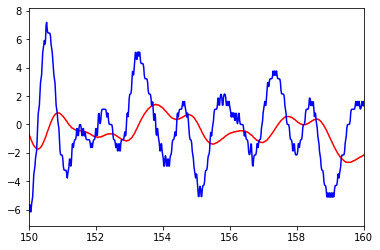

In [6]:
x = np.squeeze(annots['bin_pos'])
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
dt = 1./60
T=np.squeeze(annots['diode_BT'])
v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
#v = np.diff(x)/dt
x=x[1:-1]
v=v[1:-1] #cut ends.  V(n) = X(n) -X(n-1)
T=T[1:-1]
#plt.plot(T,L[1:-1], 'm-')
plt.plot(T,x, 'r-')
plt.plot(T,v, 'b-')
plt.xlim(150,160)

In [1]:
realr, edges = np.histogram(annots['reconstruct_spikes'][0][channelnumber], np.append(0,T))

np.unique(realr)

NameError: name 'np' is not defined

In [8]:
(len(realr)-(np.shape(np.where(realr==0))[1]))/len(realr) #non-zero state percentage

0.02149522328371473

In [9]:
deltaT =0.6
r = x+v*deltaT
rstate=np.zeros(len(r))
model = 2
if model == 0:
    counter = 0
    for n in np.arange(1, max(realr)+1):
        edge = np.sort(r)[counter]
        counter += round((np.shape(np.where(realr==n))[1])/(len(r)-(np.shape(np.where(realr==0))[1]))*len(r))
        rstate[r>=edge] = np.random.poisson(n)
    randomly_not_fire = np.append(np.ones(len(r)-(np.shape(np.where(realr==0))[1])), np.zeros(np.shape(np.where(realr==0))[1]))
    np.random.shuffle(randomly_not_fire)
    rstate = rstate*randomly_not_fire
    rstate = rstate.astype(int)
elif model == 1:
    edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
    rstate=np.zeros(len(r))
    for i in range(4):
        rstate[r>=edges[i]] = i
else:
    rstate = realr

In [11]:
#rstate = np.random.poisson(rstate)
num_state = 8
xstate = EqualState(x, num_state)
vstate = EqualState(v, num_state)
#calculate information
window = [-1,1] # second
negshift=window[0] # second
posshift=window[1] # second
shiftlen=(posshift-negshift)/dt+1
timeshift=np.linspace(negshift,posshift,int(shiftlen))
bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
Redun =np.zeros(len(bitshift))
MIxr=np.zeros(len(bitshift))
MIvr=np.zeros(len(bitshift))
MIxvR=np.zeros(len(bitshift))
MIxr_x1=np.zeros((num_state, len(bitshift)))
MIxr_x2=np.zeros((num_state, len(bitshift)))
# shifted data
# shift>0 => y shifted to positive side
for i in range(len(bitshift)):
    xx=[]
    vv=[]
    rr=[]
    shift=bitshift[i]
    if shift>0:
        xx=xstate[shift:]
        vv=vstate[shift:]
        rr=rstate[:(-1*shift)]
    elif shift==0:
        xx=xstate
        vv=vstate
        rr=rstate
    elif shift<0:
        xx=xstate[:shift]
        vv=vstate[:shift]
        rr=rstate[(-1*shift):]
    #find weight of each states by 3D histogram 
    xedges = np.append(np.unique(xx),(max(xx)+1))
    vedges = np.append(np.unique(vv),(max(vv)+1))
    redges = np.append(np.unique(rr),(max(rr)+1))
    dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
    N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
    #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
    px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
    pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
    pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
    pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
    pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
    pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
    pxvr=(N/np.sum(N))

    MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
    MIxr_x1[:,i]=np.nansum(pxr*np.log2(pxr/px/pr), axis=(1,2))/dt
    MIxr_x2[:,i]=np.nansum(pxr*np.log2(pxr/px), axis=(1,2))/dt - np.nansum(pr*px*np.log2(pr), axis=(1,2))/dt
    MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
    MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt

    PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
    PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
    Redun[i] = sum(np.minimum(PI_xR, PI_vR))/dt
    


[-3.19246492 -1.15752609 -0.65771655 -0.33641042 -0.05080497  0.27050116
  0.66320866  1.19871888]
[-6.42565994 -2.14303333 -1.3318721  -0.78038818 -0.          0.7792415
  1.30339241  2.14303333]


C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multi

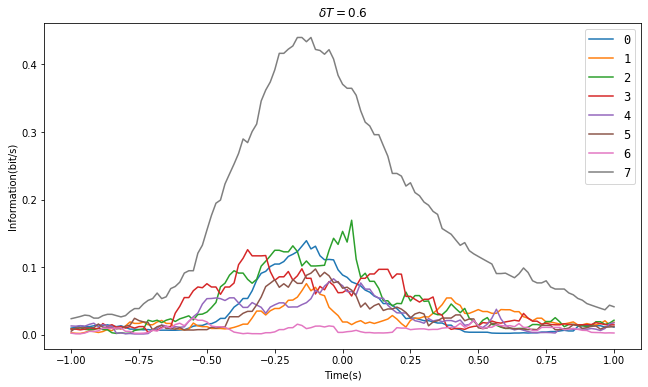

In [12]:
legend = []
for i in range(num_state):
    plt.plot(timeshift,MIxr_x1[i])
    legend.append(str(i))
plt.title('specific surprise '+r'($\delta T=$'+str(deltaT)+ ')')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (legend), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()

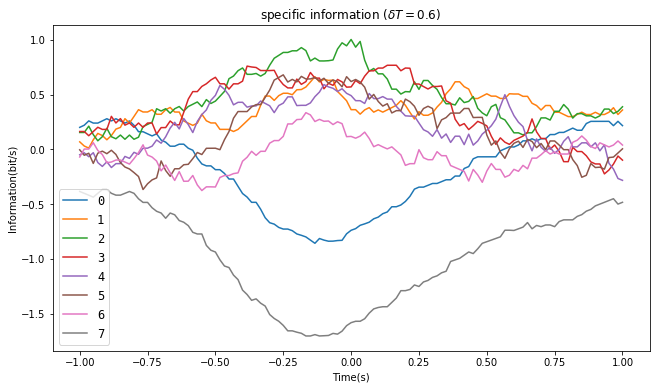

In [15]:
legend = []
for i in range(num_state):
    plt.plot(timeshift,MIxr_x2[i])
    legend.append(str(i))
plt.title('specific information '+r'($\delta T=$'+str(deltaT)+ ')')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (legend), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()

In [ ]:
#plot MIs
plt.plot(timeshift,MIxr, 'r-')
plt.plot(timeshift,MIvr, 'b-')
plt.plot(timeshift,MIxvR, 'k-')
plt.plot(timeshift,MIxr+MIvr, 'm-')
plt.title('Mutual Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.savefig(str(deltaT)+'_fake_spike_MI.tiff')

In [ ]:
Ux = MIxr-Redun
Uv = MIvr-Redun
Syner = MIxvR-MIxr-MIvr+Redun
#plot PI
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')
plt.title(r'$\delta T=$'+str(deltaT))
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()

In [ ]:
for n in np.unique(realr):
    fig, ax = plt.subplots()
    hst = ax.hist(r[np.where(realr == n)])